In [1]:
from openmmtools.constants import kB
from simtk import unit
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import mdtraj as md
import nglview
from rdkit import Chem
from rdkit.Chem import AllChem
import neutromeratio
import matplotlib.pyplot as plt
import pickle
import torchani
import torch

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 2
to_mol_tautomer_idx = 1


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

[utils.py:48 - get_donor_atom_idx()] Index of atom that moves: 14.
[utils.py:54 - get_donor_atom_idx()] Index of atom that donates hydrogen: 5
[utils.py:72 - get_donor_atom_idx()] Index of atom that accepts hydrogen: 2


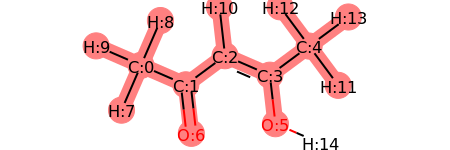

In [3]:
# extract hydrogen donor idx and hydrogen idx for from_mol
tautomer_transformation = neutromeratio.get_donor_atom_idx(from_mol, to_mol)
platform = 'cpu'
device = torch.device(platform)
model = torchani.models.ANI1ccx()
model = model.to(device)
torch.set_num_threads(2)

energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['atom_list'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation)

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)


In [ ]:
n_steps = 100000
x0 = np.array(ani_input['coord_list']) * unit.angstrom
trajectory = langevin.run_dynamics(x0, n_steps)
traj_in_nm = [x / unit.nanometer for x in trajectory]

In [ ]:
run = 1
topology = md.load(f"../data/md_sampling/{name}/{name}_t{from_mol_tautomer_idx}.pdb").topology
ani_traj = md.Trajectory(traj_in_nm, topology)
ani_traj.save(f"../data/md_sampling/{name}/{name}_t{from_mol_tautomer_idx}_run{run}_anicxx.dcd")


In [ ]:
run = 1
topology = md.load(f"../data/md_sampling/{name}/{name}_t{from_mol_tautomer_idx}.pdb").topology
traj_file = f"../data/md_sampling/{name}/{name}_t{from_mol_tautomer_idx}_run{run}_anicxx.dcd"
ani_traj = md.load(traj_file, top=topology)

view = nglview.show_mdtraj(ani_traj[::10])
view

In [ ]:
#from nglview.contrib.movie import MovieMaker
#movie = MovieMaker(view, output='my.gif')
#movie.make()